# Vehicle Detection using Single Shot Multibox Detector (SSD)

In [233]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image

from ssd_utils import BBoxUtility

%matplotlib inline

classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']

## SSD Model Architecture

In [234]:
import keras.backend as K
from keras.layers import Activation
from keras.layers import AtrousConvolution2D
from keras.layers import Convolution2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import merge
from keras.layers import Reshape
from keras.layers import ZeroPadding2D
from keras.models import Model

from ssd_layers import Normalize
from ssd_layers import PriorBox


def SSD300(input_shape, num_classes=21):
    """SSD300 architecture.

    # Arguments
        input_shape: Shape of the input image,
            expected to be either (300, 300, 3) or (3, 300, 300)(not tested).
        num_classes: Number of classes including background.

    # References
        https://arxiv.org/abs/1512.02325
        https://github.com/rykov8/ssd_keras
    """
    net = {}
    # Block 1
    input_tensor = input_tensor = Input(shape=input_shape)
    img_size = (input_shape[1], input_shape[0])
    net['input'] = input_tensor
    net['conv1_1'] = Convolution2D(64, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_1')(net['input'])
    net['conv1_2'] = Convolution2D(64, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv1_2')(net['conv1_1'])
    net['pool1'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool1')(net['conv1_2'])
    # Block 2
    net['conv2_1'] = Convolution2D(128, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_1')(net['pool1'])
    net['conv2_2'] = Convolution2D(128, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv2_2')(net['conv2_1'])
    net['pool2'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool2')(net['conv2_2'])
    # Block 3
    net['conv3_1'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_1')(net['pool2'])
    net['conv3_2'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_2')(net['conv3_1'])
    net['conv3_3'] = Convolution2D(256, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv3_3')(net['conv3_2'])
    net['pool3'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool3')(net['conv3_3'])
    # Block 4
    net['conv4_1'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_1')(net['pool3'])
    net['conv4_2'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_2')(net['conv4_1'])
    net['conv4_3'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv4_3')(net['conv4_2'])
    net['pool4'] = MaxPooling2D((2, 2), strides=(2, 2), border_mode='same',
                                name='pool4')(net['conv4_3'])
    # Block 5
    net['conv5_1'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_1')(net['pool4'])
    net['conv5_2'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_2')(net['conv5_1'])
    net['conv5_3'] = Convolution2D(512, 3, 3,
                                   activation='relu',
                                   border_mode='same',
                                   name='conv5_3')(net['conv5_2'])
    net['pool5'] = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same',
                                name='pool5')(net['conv5_3'])
    # FC6
    net['fc6'] = AtrousConvolution2D(1024, 3, 3, atrous_rate=(6, 6),
                                     activation='relu', border_mode='same',
                                     name='fc6')(net['pool5'])

    # FC7
    net['fc7'] = Convolution2D(1024, 1, 1, activation='relu',
                               border_mode='same', name='fc7')(net['fc6'])

    # Block 6
    net['conv6_1'] = Convolution2D(256, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv6_1')(net['fc7'])
    net['conv6_2'] = Convolution2D(512, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv6_2')(net['conv6_1'])
    # Block 7
    net['conv7_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv7_1')(net['conv6_2'])
    net['conv7_2'] = ZeroPadding2D()(net['conv7_1'])
    net['conv7_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='valid',
                                   name='conv7_2')(net['conv7_2'])
    # Block 8
    net['conv8_1'] = Convolution2D(128, 1, 1, activation='relu',
                                   border_mode='same',
                                   name='conv8_1')(net['conv7_2'])
    net['conv8_2'] = Convolution2D(256, 3, 3, subsample=(2, 2),
                                   activation='relu', border_mode='same',
                                   name='conv8_2')(net['conv8_1'])
    # Last Pool
    net['pool6'] = GlobalAveragePooling2D(name='pool6')(net['conv8_2'])
    # Prediction from conv4_3
    net['conv4_3_norm'] = Normalize(20, name='conv4_3_norm')(net['conv4_3'])
    num_priors = 3
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_loc'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_loc_flat')
    net['conv4_3_norm_mbox_loc_flat'] = flatten(net['conv4_3_norm_mbox_loc'])
    name = 'conv4_3_norm_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv4_3_norm'])
    net['conv4_3_norm_mbox_conf'] = x
    flatten = Flatten(name='conv4_3_norm_mbox_conf_flat')
    net['conv4_3_norm_mbox_conf_flat'] = flatten(net['conv4_3_norm_mbox_conf'])
    priorbox = PriorBox(img_size, 30.0, aspect_ratios=[2],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv4_3_norm_mbox_priorbox')
    net['conv4_3_norm_mbox_priorbox'] = priorbox(net['conv4_3_norm'])
    # Prediction from fc7
    num_priors = 6
    net['fc7_mbox_loc'] = Convolution2D(num_priors * 4, 3, 3,
                                        border_mode='same',
                                        name='fc7_mbox_loc')(net['fc7'])
    flatten = Flatten(name='fc7_mbox_loc_flat')
    net['fc7_mbox_loc_flat'] = flatten(net['fc7_mbox_loc'])
    name = 'fc7_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    net['fc7_mbox_conf'] = Convolution2D(num_priors * num_classes, 3, 3,
                                         border_mode='same',
                                         name=name)(net['fc7'])
    flatten = Flatten(name='fc7_mbox_conf_flat')
    net['fc7_mbox_conf_flat'] = flatten(net['fc7_mbox_conf'])
    priorbox = PriorBox(img_size, 60.0, max_size=114.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='fc7_mbox_priorbox')
    net['fc7_mbox_priorbox'] = priorbox(net['fc7'])
    # Prediction from conv6_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv6_2_mbox_loc')(net['conv6_2'])
    net['conv6_2_mbox_loc'] = x
    flatten = Flatten(name='conv6_2_mbox_loc_flat')
    net['conv6_2_mbox_loc_flat'] = flatten(net['conv6_2_mbox_loc'])
    name = 'conv6_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv6_2'])
    net['conv6_2_mbox_conf'] = x
    flatten = Flatten(name='conv6_2_mbox_conf_flat')
    net['conv6_2_mbox_conf_flat'] = flatten(net['conv6_2_mbox_conf'])
    priorbox = PriorBox(img_size, 114.0, max_size=168.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv6_2_mbox_priorbox')
    net['conv6_2_mbox_priorbox'] = priorbox(net['conv6_2'])
    # Prediction from conv7_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv7_2_mbox_loc')(net['conv7_2'])
    net['conv7_2_mbox_loc'] = x
    flatten = Flatten(name='conv7_2_mbox_loc_flat')
    net['conv7_2_mbox_loc_flat'] = flatten(net['conv7_2_mbox_loc'])
    name = 'conv7_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv7_2'])
    net['conv7_2_mbox_conf'] = x
    flatten = Flatten(name='conv7_2_mbox_conf_flat')
    net['conv7_2_mbox_conf_flat'] = flatten(net['conv7_2_mbox_conf'])
    priorbox = PriorBox(img_size, 168.0, max_size=222.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv7_2_mbox_priorbox')
    net['conv7_2_mbox_priorbox'] = priorbox(net['conv7_2'])
    # Prediction from conv8_2
    num_priors = 6
    x = Convolution2D(num_priors * 4, 3, 3, border_mode='same',
                      name='conv8_2_mbox_loc')(net['conv8_2'])
    net['conv8_2_mbox_loc'] = x
    flatten = Flatten(name='conv8_2_mbox_loc_flat')
    net['conv8_2_mbox_loc_flat'] = flatten(net['conv8_2_mbox_loc'])
    name = 'conv8_2_mbox_conf'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Convolution2D(num_priors * num_classes, 3, 3, border_mode='same',
                      name=name)(net['conv8_2'])
    net['conv8_2_mbox_conf'] = x
    flatten = Flatten(name='conv8_2_mbox_conf_flat')
    net['conv8_2_mbox_conf_flat'] = flatten(net['conv8_2_mbox_conf'])
    priorbox = PriorBox(img_size, 222.0, max_size=276.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='conv8_2_mbox_priorbox')
    net['conv8_2_mbox_priorbox'] = priorbox(net['conv8_2'])
    # Prediction from pool6
    num_priors = 6
    x = Dense(num_priors * 4, name='pool6_mbox_loc_flat')(net['pool6'])
    net['pool6_mbox_loc_flat'] = x
    name = 'pool6_mbox_conf_flat'
    if num_classes != 21:
        name += '_{}'.format(num_classes)
    x = Dense(num_priors * num_classes, name=name)(net['pool6'])
    net['pool6_mbox_conf_flat'] = x
    priorbox = PriorBox(img_size, 276.0, max_size=330.0, aspect_ratios=[2, 3],
                        variances=[0.1, 0.1, 0.2, 0.2],
                        name='pool6_mbox_priorbox')
    if K.image_dim_ordering() == 'tf':
        target_shape = (1, 1, 256)
    else:
        target_shape = (256, 1, 1)
    net['pool6_reshaped'] = Reshape(target_shape,
                                    name='pool6_reshaped')(net['pool6'])
    net['pool6_mbox_priorbox'] = priorbox(net['pool6_reshaped'])
    # Gather all predictions
    net['mbox_loc'] = merge([net['conv4_3_norm_mbox_loc_flat'],
                             net['fc7_mbox_loc_flat'],
                             net['conv6_2_mbox_loc_flat'],
                             net['conv7_2_mbox_loc_flat'],
                             net['conv8_2_mbox_loc_flat'],
                             net['pool6_mbox_loc_flat']],
                            mode='concat', concat_axis=1, name='mbox_loc')
    net['mbox_conf'] = merge([net['conv4_3_norm_mbox_conf_flat'],
                              net['fc7_mbox_conf_flat'],
                              net['conv6_2_mbox_conf_flat'],
                              net['conv7_2_mbox_conf_flat'],
                              net['conv8_2_mbox_conf_flat'],
                              net['pool6_mbox_conf_flat']],
                             mode='concat', concat_axis=1, name='mbox_conf')
    net['mbox_priorbox'] = merge([net['conv4_3_norm_mbox_priorbox'],
                                  net['fc7_mbox_priorbox'],
                                  net['conv6_2_mbox_priorbox'],
                                  net['conv7_2_mbox_priorbox'],
                                  net['conv8_2_mbox_priorbox'],
                                  net['pool6_mbox_priorbox']],
                                 mode='concat', concat_axis=1,
                                 name='mbox_priorbox')
    if hasattr(net['mbox_loc'], '_keras_shape'):
        num_boxes = net['mbox_loc']._keras_shape[-1] // 4
    elif hasattr(net['mbox_loc'], 'int_shape'):
        num_boxes = K.int_shape(net['mbox_loc'])[-1] // 4
    net['mbox_loc'] = Reshape((num_boxes, 4),
                              name='mbox_loc_final')(net['mbox_loc'])
    net['mbox_conf'] = Reshape((num_boxes, num_classes),
                               name='mbox_conf_logits')(net['mbox_conf'])
    net['mbox_conf'] = Activation('softmax',
                                  name='mbox_conf_final')(net['mbox_conf'])
    net['predictions'] = merge([net['mbox_loc'],
                               net['mbox_conf'],
                               net['mbox_priorbox']],
                               mode='concat', concat_axis=2,
                               name='predictions')
    model = Model(net['input'], net['predictions'])
    return model

## Model loading and setup

Training the model requires GPUs and is very time consuming. Here I load pre-trained weights downloaded from https://github.com/rykov8/ssd_keras and also define a bounding box utility to help decode the outputs.

In [235]:
model = SSD300((300, 300, 3))
model.load_weights('weights_SSD300.hdf5')
bbox_util = BBoxUtility(len(classes)+1)

## Pipeline definition

The pipeline consists of two main functions. The loaded image/frame gets passed to the process_frame function and then some preprocessing is done on it. After that, we predict the output using the model we loaded above, and then we decode the output using the bounding box utility.
After that, further decoding is done on the output to find the highest probability that this box refers to a car. I used a threshold of 0.6.

In [236]:
def decode_output(out, thresh=0.6):
    out_label  = out[0][:,0]
    conf_score = out[0][:,1]
    x1         = out[0][:,2]
    y1         = out[0][:,3]
    x2         = out[0][:,4]
    y2         = out[0][:,5]
    
    indices = []
    for i in range(len(conf_score)):
        if conf_score[i] >= thresh and out_label[i] == 7:
            indices.append(i)
    
    return conf_score[indices], out_label[indices].tolist(), x1[indices], y1[indices], x2[indices], y2[indices]

def process_frame(img):
    img_pr = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
    inputs = preprocess_input(np.array([image.img_to_array(img_pr).copy()]))
    
    preds = model.predict(inputs, batch_size=1, verbose=0)
    out = bbox_util.detection_out(preds)
    
    conf, labels, x1, y1, x2, y2 = decode_output(out, 0.6)

    for i in range(len(conf)):
        xmin = int(round(x1[i] * img.shape[1]))
        ymin = int(round(y1[i] * img.shape[0]))
        xmax = int(round(x2[i] * img.shape[1]))
        ymax = int(round(y2[i] * img.shape[0]))
        score=conf[i]
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 3)
        cv2.putText(img, str(round(score*100, 2))+'%', (xmin,ymin-6), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,0),2,cv2.LINE_AA)
    
    return img

## Running the pipeline on test images

In this part, All the test images from the test_images folder are loaded, and the pipeline is run on them. You can find the outputs in out_images/

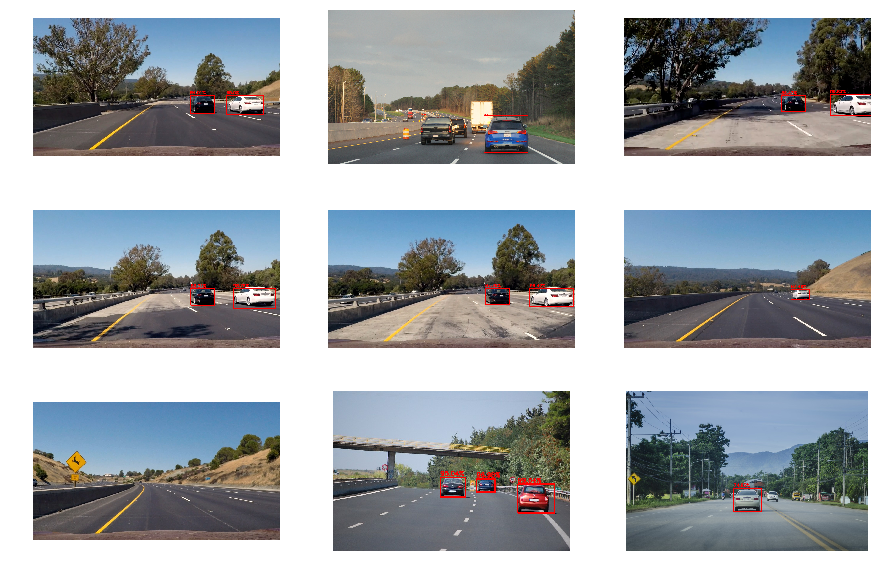

In [241]:
files = glob.glob("./test_images/*.jpg")

plt.figure(figsize=(15,10))

i = 1

for f in files:
    img = cv2.imread(f)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    out_img = process_frame(img)
    
    cv2.imwrite('./out_images/'+f[14:-4]+'_out.jpg', cv2.cvtColor(out_img, cv2.COLOR_RGB2BGR))
    
    plt.subplot(3, 3, i)
    plt.imshow(out_img)
    plt.axis('off')
    
    i += 1
    
plt.show()

## Loading video files and processing them

Here we load all the video files from the directory and run the pipeline on them.

In [246]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

vids = glob.glob("./videos/*.mp4")
for i in range(len(vids)):
    # do not process already processed videos.
    if (vids[i][-5] == 'd'):
        continue
    out_name = vids[i][2:-4] + '_processed.mp4'
    clip = VideoFileClip(vids[i])
    white_clip = clip.fl_image(process_frame)
    %time white_clip.write_videofile(out_name, audio=False)

./videos/project_video.mp4
./videos/my_video_2.mp4
./videos/my_video_1.mp4
./videos/test_video.mp4
